# Elman

Elman网络大致可分为四层：输入层、隐藏层、承接层和输出层

* 输入层：接受信号输入
* 隐藏层：线性以及非线性变换
* 输出层：加权输出
* 承接层：承接上一时刻的信息

相较于简单的BP网络，Elman网络具有承接层，从而对序列数据具有记忆能力，实现动态建模

## 符号定义

|符号|含义|
|:-:|:-:|
|$\bm{x(t)}$|t时刻的输入信号|
|$\bm{h}$|隐藏层输出|
|$\bm{\hat{y}}$|模型预测输出|
|$\bm{y}$|输入信号对应的真实输出|
|$\_i$|索引为i的值|
|$^j\_i$|第j个向量索引为i的值|
|$\bm{V}$|输入层到隐藏层的连接权矩阵|
|$\bm{b_1}$|输入层到隐藏层的偏置|
|$\bm{W}$|隐藏层到输出层的连接权矩阵|
|$\bm{b_2}$|隐藏层到输出层的偏置|
|$\bm{U}$|承接层到隐藏层的连接权矩阵|
|$f$|隐藏层激活函数|
|$g$|输出层激活函数|
|$n$|输入信号维度|
|$k$|隐藏层维度|
|$o$|输出层维度|
|$d$|训练集总数|
|$T$|总时间步|

## 正向计算

1. **输入层与承接层信号到隐藏层**
$$
\begin{equation}
    \begin{split}
        \bm{h(t)} 
        &= f(\bm{V}, \bm{U}, \bm{x(t)}, \bm{h(t-1)}, \bm{b_1}) \\
        &= f(\bm{V}\bm{x(t)} + \bm{U}\bm{h(t-1)} + \bm{b_1})
    \end{split}
\end{equation}
$$
2. **隐藏层到输出层**
$$
\begin{equation}
    \begin{split}
        \bm{\hat{y}(t)} 
        &= g(\bm{W}, \bm{h(t)}, \bm{b_2}) \\
        &= g(\bm{W} \bm{h(t)} + \bm{b_2})
    \end{split}
\end{equation}
$$
3. **损失计算**
* 单个训练样本的损失
Elman要求t个时刻的损失均计入总损失，在这里使用$l_2$损失，当然，随着任务类型的变换可以换为交叉熵等
$$
\begin{equation}
    \mathcal{L_j(\bm{V}, \bm{W}, \bm{U}, \bm{b_1}, \bm{b_2})} = \sum_{t=1}^T||\bm{\hat{y(t)}^j}-\bm{y(t)^j}||_2^2
\end{equation}
$$
* 训练集总损失
$$
\begin{equation}
    \mathcal{L(\bm{V}, \bm{W}, \bm{U}, \bm{b_1}, \bm{b_2})} = \sum_{j=1}^d\sum_{t=1}^T ||\bm{\hat{y(t)}^j}-\bm{y(t)^j}||_2^2
\end{equation}
$$

## 误差传递与参数更新

上述正向推理和BP网络基本一致，唯一不同的是在输入层到隐藏层的时候需要同时考虑当前时刻的输入和上一时刻隐藏层的输出。

这里值得注意的是：

上述流程虽然看起来存在环，但是实际上是不存在的。Elman依然是**有向无环**的结构。一般Elman示意图会将上一时刻和当前时刻绘制在同一张图中，但是其结构可以展开为下图的结构。显然，对于当前时刻，整个模型并不存在环，虽然误差会在不同时刻的参数中传递，但是并不会形成环。

![Elman](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/Elman.png "segment")

值得注意的是，Elman展开后虽然为一个有向无环图，但是其中的权重在不同时刻是**共享**的。

说回来，如果真的是有向有环图，Elman网络也不可能使用梯度下降法进行优化了

Elman网络的优化方法有两大类，分别为**实时循环学习(Real-Time Recurrent Learning, RTRL)**和**时序反向传播(BackPropagation Through Time, BPTT)**。这两类方法均基于BP算法，不同在于，RTRL在前向计算时就计算梯度并在每一个时间步更新参数，BPTT则在完成所有时间步的运算后进行梯度反向传播和参数更新。显然，BPTT需要保存大量的中间结果，其存储开销大；而RTRL则不需要存储多余的中间结果，其存储开销小，但是运算量大。

在这里，主要是对BPTT进行推导

### BPTT

* 单时间步(单样本)
首先考虑仅有一个时间步，并将偏执并入权值，此时不存在沿时间的误差传递
    * $\bm{W}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{W}}
        &= \frac{\partial \mathcal{L}}{\partial \bm{W}\bm{h(1)}}\frac{\partial \bm{W}\bm{h(1)}}{\partial \bm{W}}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{W}\bm{h}(1)}
        &= 2(\bm{\hat{y}(1)}-\bm{y(1)})^Tdiag(g^{\prime}(\bm{W}\bm{h}(1))) \\
        &= \bm{\delta_1(1)}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{W}}
        &= \bm{\delta_1(1)}^T\bm{h}(1)^T
    \end{split}
\end{equation}
$$
    * $\bm{h}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{h}(1)}
        &= \frac{\partial \mathcal{L}}{\partial \bm{W}\bm{h}(1)}\frac{\partial \bm{W}\bm{h}(1)}{\partial \bm{h}(1)} \\ 
        &= \bm{\delta_1(1)}\bm{W}
    \end{split}
\end{equation}
$$

    * $\bm{V}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{V}}
        &= \frac{\partial \mathcal{L}}{\partial \bm{V}\bm{x}(1)}\frac{\partial \bm{V}\bm{x}(1)}{\partial \bm{V}}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{V}\bm{x}(1)}
        &= \frac{\partial \mathcal{L}}{\partial \bm{h}(1)}\frac{\partial \bm{h}(1)}{\partial \bm{V}\bm{x}(1)} \\
        &= \bm{\delta_1(1)}\bm{W}diag(f^{\prime}(\bm{V\bm{x}(1)})) \\
        &= \bm{\delta_2}(1)
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{V}}
        &= \bm{\delta_2}(1)^T\bm{x}(1)^T
    \end{split}
\end{equation}
$$

    * $\bm{U}$
    由于仅有一个时间步，$\bm{h}(0)=\bm{0}$，因此损失对$\bm{U}$的偏导为0

* 2时间步
同理可得
    * $\bm{W}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{W}}
        &= \bm{\delta_1(2)}^T\bm{h}(2)^T
    \end{split}
\end{equation}
$$
    * $\bm{h}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{h}(2)}
        &= \frac{\partial \mathcal{L}}{\partial \bm{W}\bm{h}(2)}\frac{\partial \bm{W}\bm{h}(2)}{\partial \bm{h}(2)} \\ 
        &= \bm{\delta_1(2)}\bm{W}
    \end{split}
\end{equation}
$$
    * $\bm{V}$
$$
\begin{equation}
    \frac{\partial \mathcal{L}}{\partial \bm{V}} = \frac{\partial \mathcal{L}}{\partial \bm{h}(2)}(\frac{\partial \bm{h}(2)}{\partial \bm{V}} + \frac{\partial \bm{h}(2)}{\partial \bm{h}(1)}\frac{\partial \bm{h(1)}}{\partial \bm{V}})
\end{equation}
$$
上式和仅有一个时间步的计算显然不同，这是由于对于权重矩阵$\bm{V}$，其不仅用于计算当前时刻的隐藏层输出，还应用于计算上一时刻的隐藏层输出，因此在计算梯度时，应当沿着时序进行反向传播
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{h}(2)}\frac{\partial \bm{h}(2)}{\partial \bm{h}(1)}
    &= \frac{\partial \mathcal{L}}{\partial \bm{h}(2)}\frac{\partial \bm{h}(2)}{\partial \bm{U}\bm{h}(1)}\frac{\partial \bm{U}\bm{h}(1)}{\partial \bm{h}(1)}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{U}\bm{h}(1)}
    &= \bm{\delta_1(2)}\bm{W}diag(f^{\prime}(\bm{V}\bm{x}(2)+\bm{U}\bm{h}(1))) \\
    &= \bm{\delta_3(2)}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{h}(1)}
    &= \frac{\partial \mathcal{L}}{\partial \bm{U}\bm{h}(1)}\frac{\partial \bm{U}\bm{h}(1)}{\bm{h}(1)} \\
    &= \bm{\delta_3(2)}\bm{U}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{V}}
    &= \bm{\delta_2}(2)^T\bm{x}(2)^T + \frac{\partial \mathcal{L}}{\partial \bm{h}(1)}\frac{\partial \bm{h}(1)}{\partial \bm{V}} \\
    &= \bm{\delta_2}(2)^T\bm{x}(2)^T + \frac{\partial \mathcal{L}}{\partial \bm{h}(1)}(\frac{\partial \bm{h}(1)}{\partial \bm{V}\bm{x(1)}}\frac{\partial \bm{V}\bm{x(1)}}{\partial \bm{V}} + \frac{\partial \bm{h}(1)}{\partial \bm{U}\bm{h(0)}}\frac{\partial \bm{U}\bm{h(0)}}{\partial \bm{V}}) \\
    &= \bm{\delta_2}(2)^T\bm{x}(2)^T + (\bm{\delta_3(2)}\bm{U}diag(f^{\prime}(\bm{V}\bm{x(1)})))^T\bm{x(1)}^T
    \end{split} 
\end{equation}
$$
    * $\bm{U}$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{U}} 
    &= \frac{\partial \mathcal{L}}{\partial \bm{h(2)}}(\frac{\partial \bm{h(2)}}{\partial \bm{U}}+\frac{\partial \bm{h(2)}}{\partial \bm{h(1)}}\frac{\partial \bm{h(1)}}{\partial \bm{U}}) \\
    &= \frac{\partial \mathcal{L}}{\partial \bm{U}\bm{h}(1)}\frac{\partial \bm{U}\bm{h}(1)}{\partial \bm{U}} + \frac{\partial \mathcal{L}}{\partial \bm{h}(1)}\frac{\partial \bm{h}(1)}{\partial \bm{U}} \\
    &= \bm{\delta_3(2)}^T\bm{h}(1)^T
    \end{split}
\end{equation}
$$

* t时间步
同上有
    * $\bm{W}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{W}}
        &= \bm{\delta_1(t)}^T\bm{h}(t)^T
    \end{split}
\end{equation}
$$
    * $\bm{h}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{h}(t)}
        &= \frac{\partial \mathcal{L}}{\partial \bm{W}\bm{h}(t)}\frac{\partial \bm{W}\bm{h}(t)}{\partial \bm{h}(t)} \\ 
        &= \bm{\delta_1(t)}\bm{W}
    \end{split}
\end{equation}
$$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{h}(t-1)}
        &= \frac{\partial \mathcal{L}}{\partial \bm{U}\bm{h}(t-1)}\frac{\partial \bm{U}\bm{h}(t-1)}{\partial \bm{h}(t-1)} \\ 
        &= \bm{\delta_3(t)}\bm{U}
    \end{split}
\end{equation}
$$
    * $\bm{V}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{V}}
        &= \frac{\partial \mathcal{L}}{\partial \bm{V}\bm{x(t)}}\frac{\partial \bm{V}\bm{x(t)}}{\partial \bm{V}} + \frac{\partial \mathcal{L}}{\partial \bm{h(t-1)}}\frac{\partial \bm{h(t-1)}}{\partial \bm{V}} \\
        &= \bm{\delta_2(t)}^T\bm{x(t)}^T + \bm{\delta_3(t)}\bm{U}\frac{\partial \bm{h(t-1)}}{\partial \bm{V}}
    \end{split}
\end{equation}
$$
    * $\bm{U}$
$$
\begin{equation}
    \begin{split}
        \frac{\partial \mathcal{L}}{\partial \bm{U}}
        &= \frac{\partial \mathcal{L}}{\partial \bm{U}\bm{h}(t-1)}\frac{\partial \bm{U}\bm{h}(t-1)}{\partial \bm{U}} + \frac{\partial \mathcal{L}}{\partial \bm{h}(t-1)}\frac{\partial \bm{h}(t-1)}{\partial \bm{U}} \\
        &= \bm{\delta_3(t)}^T\bm{h}(t-1)^T + \bm{\delta_3(t)}\bm{U}\frac{\partial \bm{h}(t-1)}{\partial \bm{U}}
    \end{split}
\end{equation}
$$

式-23和式-24中存在两个偏导数：$\frac{\partial \bm{h(t-1)}}{\partial \bm{V}}$和$\frac{\partial \bm{h}(t-1)}{\partial \bm{U}}$

显然，这两个偏导数是沿时间的递归公式，需要沿时间进行递归计算，而且由于是向量对矩阵的偏导，计算较为复杂

下面将使用另外一种方式进行推导

* $\bm{W}$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L(t)}}{\partial \bm{W}} 
    &= \frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\partial \bm{\hat{y(t)}}}{\partial \bm{W}\bm{h(t)}}\frac{\partial \bm{W}\bm{h(t)}}{\partial \bm{W}} \\
    &= \bm{\delta_1(t)}^T\bm{h}(t)^T
    \end{split}
\end{equation}
$$

* $\bm{V}$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L(t)}}{\partial \bm{V}}
    &= \frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\bm{\hat{y(t)}}}{\partial \bm{h(t)}}\frac{\partial \bm{h(t)}}{\partial \bm{V}} \\
    &= \sum_{q=1}^t\frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\bm{\hat{y(t)}}}{\partial \bm{h(t)}}\frac{\partial \bm{h(t)}}{\partial \bm{h(q)}}\frac{\partial \bm{h(q)}}{\partial \bm{V}} \\
    &= \sum_{q=1}^t\frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\bm{\hat{y(t)}}}{\partial \bm{h(t)}}(\prod_{j=q+1}^{t}\frac{\partial \bm{h(j)}}{\partial \bm{h(j-1)}})\frac{\partial \bm{h(q)}}{\partial \bm{V}} \\
    \end{split}
\end{equation}
$$

* $\bm{U}$
$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L(t)}}{\partial \bm{U}}
    &= \frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\bm{\hat{y(t)}}}{\partial \bm{h(t)}}\frac{\partial \bm{h(t)}}{\partial \bm{U}} \\
    &= \sum_{q=1}^t\frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\bm{\hat{y(t)}}}{\partial \bm{h(t)}}\frac{\partial \bm{h(t)}}{\partial \bm{h(q)}}\frac{\partial \bm{h(q)}}{\partial \bm{U}} \\
    &= \sum_{q=1}^t\frac{\partial \mathcal{L(t)}}{\partial \bm{\hat{y(t)}}}\frac{\bm{\hat{y(t)}}}{\partial \bm{h(t)}}(\prod_{j=q+1}^{t}\frac{\partial \bm{h(j)}}{\partial \bm{h(j-1)}})\frac{\partial \bm{h(q)}}{\partial \bm{U}} \\
    \end{split}
\end{equation}
$$

在式26、27中，将沿时间的误差反向传播完全展开，每一个$\frac{\partial \bm{h(q)}}{\partial \bm{U}}$或是$\frac{\partial \bm{h(q)}}{\partial \bm{V}}$仅要对当前层的权重进行求解，而无需沿时间迭代计算，在一定程度上降低了计算难度

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import random

# seed
random.seed(1024)
np.random.seed(1024)
%matplotlib inline

In [2]:
# 定义单隐藏层Elman神经网络

class MyElman(object):

    def __init__(self, input_dims, hidden_dims, output_dims, max_back_time_step=5):
        """
        input_dims: 输入维度
        hidden_dims: 隐藏层神经元数量
        output_dims: 输出维度
        max_back_time_step: 反向传播最大时间步数
        """

        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
        self.max_back_time_step = max_back_time_step

        # 模型权重
        random.seed(1024)
        np.random.seed(1024)
        self.weight_input2hidden = np.random.randn(hidden_dims, input_dims+1)
        self.weight_lasthidden2hidden = np.random.randn(hidden_dims, hidden_dims)
        self.weight_hidden2output = np.random.randn(output_dims, hidden_dims)
        
        # 激活函数
        self.activate = self.activate_func
        # 激活函数微分，事先准备好
        self.activate_dif = self.activate_dif_func

        # 中间结果

        # 输入数据 (input_dims, 1)
        self.input_vector = None
        # 输入数据记录 (t, input_dims, 1)
        self.input_vectors = list()

        # 隐藏层输出 (hidden_dims, 1)
        self.hidden_output_vector = None
        # 隐藏层输出记录 (t, hidden_dims, 1)
        self.hidden_output_vectors = list()
        
        # 未激活隐藏层输出 (batch, hidden_dims)
        self.hidden_output_vector_no_activate = None
        # 未激活隐藏层输出记录 (t, hidden_dims, 1)
        self.hidden_output_vectors_no_activate = list()

        # 输出 (output_dims, 1)
        self.output_vector = None
        # 输出记录 (t, output_dims, 1)
        self.output_vectors = list()

        # 梯度结果
        self.grad_hidden2output = None
        self.grad_input2hidden = None
        self.grad_lasthidden2hidden = None
    
    def cla(self):
        # 中间结果

        # 输入数据 (input_dims, 1)
        self.input_vector = None
        # 输入数据记录 (t, input_dims, 1)
        self.input_vectors = list()

        # 隐藏层输出 (hidden_dims, 1)
        self.hidden_output_vector = None
        # 隐藏层输出记录 (t, hidden_dims, 1)
        self.hidden_output_vectors = list()
        
        # 未激活隐藏层输出 (batch, hidden_dims)
        self.hidden_output_vector_no_activate = None
        # 未激活隐藏层输出记录 (t, hidden_dims, 1)
        self.hidden_output_vectors_no_activate = list()

        # 输出 (output_dims, 1)
        self.output_vector = None
        # 输出记录 (t, output_dims, 1)
        self.output_vectors = list()

        # 梯度结果
        self.grad_hidden2output = None
        self.grad_input2hidden = None
        self.grad_lasthidden2hidden = None


    def forward(self, input_data):
        """
        正向计算
        input_data: 输入数据，其长度可以任意长度
        """

        # 首先判断输入能切分为多少长度
        total_t = len(input_data)-self.input_dims
        self.cla()
        self.hidden_output_vector = np.zeros((self.hidden_dims, 1))
        for t in range(total_t):
            
            # 输入向量
            self.input_vector = input_data[t: t + self.input_dims].reshape((-1, 1))
            
            # 隐藏层输出
            expend_input_vector = np.concatenate((self.input_vector, [[1]]), axis=0)
            self.hidden_output_vector_no_activate = np.matmul(self.weight_input2hidden, expend_input_vector) + np.matmul(self.weight_lasthidden2hidden, self.hidden_output_vector)
            self.hidden_output_vector = self.activate(self.hidden_output_vector_no_activate)
            
            # 输出层输出
            self.output_vector = np.matmul(self.weight_hidden2output, self.hidden_output_vector)

            # 数据记录
            self.input_vectors.append(expend_input_vector)
            self.hidden_output_vectors.append(self.hidden_output_vector_no_activate)
            self.hidden_output_vectors_no_activate.append(self.hidden_output_vector)
            self.output_vectors.append(self.output_vector)

        return np.array(self.output_vectors)
    
    def BPTT(self, train_seq, label_list):
        """
        BPTT更新参数
        label_list: 标签序列
        """

        # 正向推理
        self.forward(train_seq)

        max_t = len(label_list)

        self.grad_input2hidden = np.zeros(self.weight_input2hidden.shape)
        self.grad_hidden2output = np.zeros(self.weight_hidden2output.shape)
        self.grad_lasthidden2hidden = np.zeros(self.weight_lasthidden2hidden.shape)

        delta_1 = np.zeros((max_t, self.output_dims))
        for t in np.arange(max_t)[::-1]:
            delta_1[t] = 2 * (self.output_vectors[t]-label_list[t]).reshape(-1)

            self.grad_hidden2output += np.outer(delta_1[t], self.hidden_output_vectors[t])

            # 初始化dL/d(Vx(t)+Uh(t-1))
            delta_t = self.weight_hidden2output.T.dot(delta_1[t].reshape(-1, 1)) * self.activate_dif_func(self.hidden_output_vectors_no_activate[t])
            for bptt_step in np.arange(max(0, t-self.max_back_time_step), t+1)[::-1]:
                self.grad_lasthidden2hidden += np.outer(delta_t, self.hidden_output_vectors[bptt_step-1])

                self.grad_input2hidden += np.outer(delta_t, self.input_vectors[bptt_step])
                
                # 更新dL/d(Vx(t)+Uh(t-1))至前一个时刻
                delta_t = self.weight_lasthidden2hidden.T.dot(delta_t) * self.activate_dif_func(self.hidden_output_vectors_no_activate[bptt_step-1])

        self.grad_input2hidden /= max_t
        self.grad_hidden2output /= max_t
        self.grad_lasthidden2hidden /= max_t

    def fit(self, train_seq, label_list, lr, iteration=1000, draw_fig=False, x_list=None):
        """
        优化
        train_seq: 训练序列
        label_list: 标签序列
        lr: 学习率
        """
        fig_count = 1
        print_frequency = 1
        plt.figure(figsize=(20, 10))
        for i in range(iteration):
            # BPTT
            self.BPTT(train_seq, label_list)

            # 参数更新
            self.weight_hidden2output -= self.grad_hidden2output * lr
            self.weight_input2hidden -= self.grad_input2hidden * lr
            self.weight_lasthidden2hidden -= self.grad_lasthidden2hidden * lr

            if i % print_frequency == 0:
                pred_list = self.forward(train_seq).reshape(-1)

                if draw_fig:
                    self.draw_func(x_list, train_seq, label_list, fig_count, iter_=i)
                    
                fig_count += 1
                print_frequency = int(pow(1.1, fig_count))

                train_loss = np.mean((pred_list-label_list)**2)
                print("[{}/{}], train_loss:{:.5f}".format(i, iteration, train_loss))
        
        pred_list = self.forward(train_seq).reshape(-1)
        train_loss = np.mean((pred_list-label_list)**2)
        print("[{}/{}], train_loss:{:.5f}".format(iteration, iteration, train_loss))

        self.draw_func(x_list, train_seq, label_list, fig_count, iter_=iteration, if_show=True)
    
    def draw_func(self, x_list, train_seq, label_list, fig_count, iter_=0, if_show=False):

        pred_list = self.forward(train_seq)

        plt.cla()
        plt.clf()
        plt.title("example & iter:{}".format(iter_), fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(x_list[self.input_dims:], label_list, label="Ground True", linewidth=3)
        plt.plot(x_list[self.input_dims:], pred_list.reshape(-1), label="Pred", linewidth=3)
        plt.legend(loc=1, fontsize=15)
        plt.savefig("./images/temp/{}.png".format(fig_count), dpi=100)
        if if_show:
            plt.show()

    @staticmethod
    def activate_func(x):
        """
        sigmoid
        """
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def activate_dif_func(activate_result):
        return activate_result*(1-activate_result)

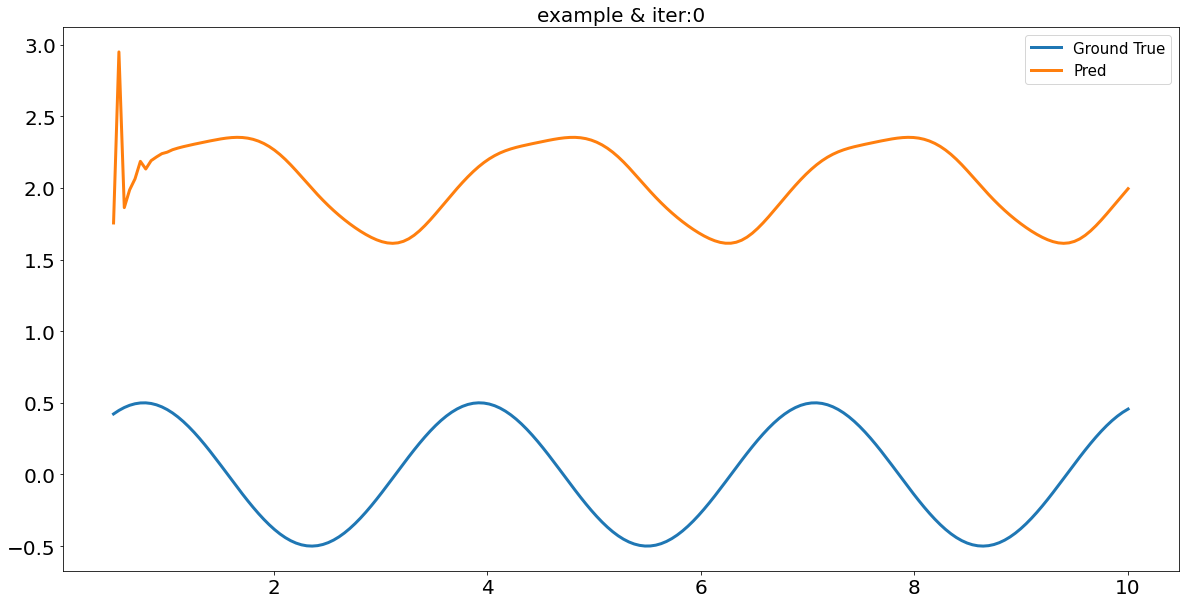

[0/6000], train_loss:3.80000
[1/6000], train_loss:3.38431
[2/6000], train_loss:3.02465
[3/6000], train_loss:2.71199
[4/6000], train_loss:2.43904
[5/6000], train_loss:2.19986
[6/6000], train_loss:1.98956
[8/6000], train_loss:1.64005
[10/6000], train_loss:1.36536
[12/6000], train_loss:1.14752
[14/6000], train_loss:0.97341
[15/6000], train_loss:0.89961
[18/6000], train_loss:0.71982
[21/6000], train_loss:0.58770
[24/6000], train_loss:0.48942
[28/6000], train_loss:0.39499
[30/6000], train_loss:0.35916
[35/6000], train_loss:0.29239
[36/6000], train_loss:0.28203
[42/6000], train_loss:0.23417
[49/6000], train_loss:0.19888
[56/6000], train_loss:0.17604
[64/6000], train_loss:0.15848
[72/6000], train_loss:0.14622
[80/6000], train_loss:0.13716
[88/6000], train_loss:0.13015
[91/6000], train_loss:0.12790
[98/6000], train_loss:0.12328
[105/6000], train_loss:0.11935
[119/6000], train_loss:0.11290
[133/6000], train_loss:0.10768
[147/6000], train_loss:0.10323
[161/6000], train_loss:0.09925
[175/6000], t

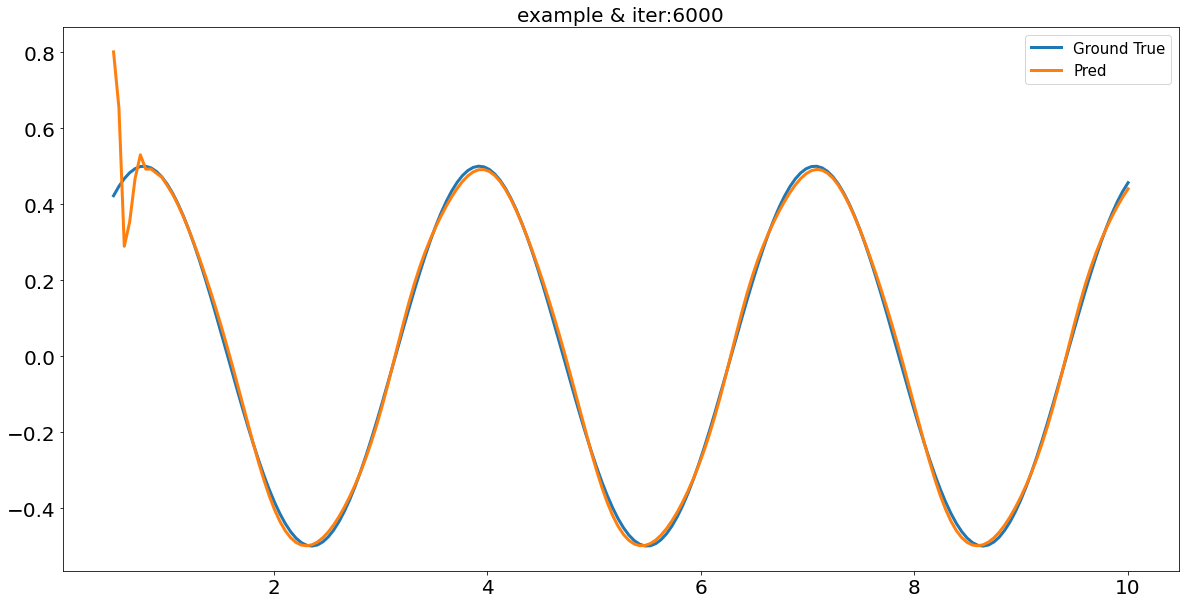

In [3]:
# ----------------------- 测试数据 ---------------------

# 输入维度
input_dims = 10
# 输出维度
output_dims = 1
# 隐藏层维度
hidden_dims = 15
# 序列总长度
seq_len = 200

# 待拟合函数 cos(x)sin(x)
def arm_func(input_x):
    return np.cos(input_x) * np.sin(input_x)

# 定义序列
x_list = np.linspace(0, 10, seq_len)
seq_data = arm_func(x_list)
# 目标输出
seq_output = seq_data[input_dims:]

# ---------------- 定义模型 --------------------
elman_nn = MyElman(input_dims, hidden_dims, output_dims, max_back_time_step=3)

# ---------------- 正向推理 --------------------
plt.figure(figsize=(20, 10))
elman_nn.draw_func(x_list, seq_data, seq_output, fig_count=0, if_show=True)

# ---------------- BPTT训练 ---------------------
elman_nn.fit(seq_data, seq_data[input_dims:], lr=0.005, iteration=6000, draw_fig=True, x_list=x_list)

# 保存gif
with imageio.get_writer("./images/{}.gif".format("ELman_regression_example_1"), mode="I", fps=5) as Writer:
    fig_num = len(os.listdir("./images/temp"))
    for ind in range(fig_num):
        image = imageio.imread("./images/temp/{}.png".format(ind))
        if ind != fig_num-1:
            os.remove("./images/temp/{}.png".format(ind))
        Writer.append_data(image)
    for i in range(10):Writer.append_data(image)
    os.remove("./images/temp/{}.png".format(fig_num-1))

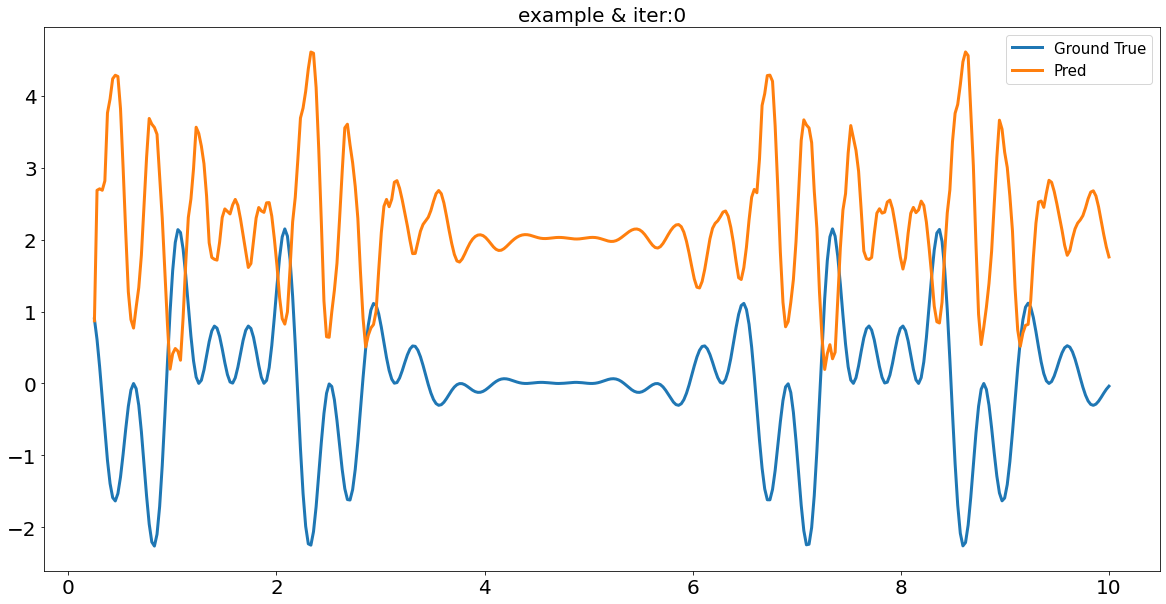

[0/4000], train_loss:6.37247
[1/4000], train_loss:5.50082
[2/4000], train_loss:4.77146
[3/4000], train_loss:4.15917
[4/4000], train_loss:3.64379
[5/4000], train_loss:3.20905
[6/4000], train_loss:2.84165
[8/4000], train_loss:2.26707
[10/4000], train_loss:1.85314
[12/4000], train_loss:1.55318
[14/4000], train_loss:1.33427
[15/4000], train_loss:1.24761
[18/4000], train_loss:1.05273
[21/4000], train_loss:0.92418
[24/4000], train_loss:0.83539
[28/4000], train_loss:0.75254
[30/4000], train_loss:0.72042
[35/4000], train_loss:0.65579
[36/4000], train_loss:0.64474
[42/4000], train_loss:0.58686
[49/4000], train_loss:0.53216
[56/4000], train_loss:0.48704
[64/4000], train_loss:0.44439
[72/4000], train_loss:0.40918
[80/4000], train_loss:0.37986
[88/4000], train_loss:0.35526
[91/4000], train_loss:0.34706
[98/4000], train_loss:0.32982
[105/4000], train_loss:0.31489
[119/4000], train_loss:0.29065
[133/4000], train_loss:0.27218
[147/4000], train_loss:0.25794
[161/4000], train_loss:0.24679
[175/4000], t

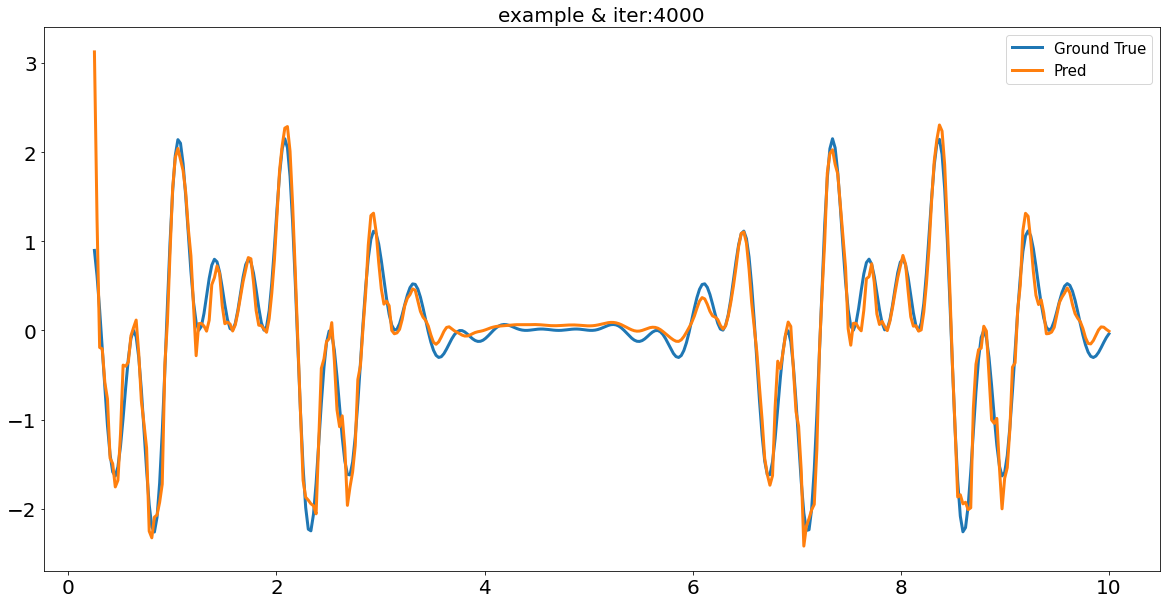

In [5]:
# ----------------------- 测试数据 ---------------------

# 输入维度
input_dims = 10
# 输出维度
output_dims = 1
# 隐藏层维度
hidden_dims = 15
# 序列总长度
seq_len = 400

# 待拟合函数
def arm_func(input_x):
    return np.cos(input_x) * np.sin(input_x * 10) * np.sin(input_x * 5) * np.exp(np.sin(input_x)*2)

# 定义序列
x_list = np.linspace(0, 10, seq_len)
seq_data = arm_func(x_list)
# 目标输出
seq_output = seq_data[input_dims:]

# ---------------- 定义模型 --------------------
elman_nn = MyElman(input_dims, hidden_dims, output_dims, max_back_time_step=3)

# ---------------- 正向推理 --------------------
plt.figure(figsize=(20, 10))
elman_nn.draw_func(x_list, seq_data, seq_output, fig_count=0, if_show=True)

# ---------------- BPTT训练 ---------------------
elman_nn.fit(seq_data, seq_data[input_dims:], lr=0.005, iteration=4000, draw_fig=True, x_list=x_list)

# 保存gif
with imageio.get_writer("./images/{}.gif".format("ELman_regression_example_2"), mode="I", fps=5) as Writer:
    fig_num = len(os.listdir("./images/temp"))
    for ind in range(fig_num):
        image = imageio.imread("./images/temp/{}.png".format(ind))
        if ind != fig_num-1:
            os.remove("./images/temp/{}.png".format(ind))
        Writer.append_data(image)
    for i in range(10):Writer.append_data(image)
    os.remove("./images/temp/{}.png".format(fig_num-1))